In [1]:
import pandas as pd
import h5py
import numpy as np
import scipy
import simweights
import nuflux
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
%matplotlib inline
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from matplotlib.ticker import LogLocator
import pickle
nu_bins = np.logspace(3,7,28)
mu_bins = np.logspace(1,7,50)
mu_bin_centers = np.sqrt(mu_bins[:-1]*mu_bins[:1])
zen_bins = np.linspace(0,1,6)
depth_bins = [1400,1600,2000,2100,2500,2700]
selected_nu_bins = np.array([
    1000., #1 TeV
    2000., #2 TeV
    4000., #4 TeV
    6300., #6.3 TeV
    10000.,#10 TeV
    20000., #20 TeV
    100000., #100 TeV
])

selected_mu_bins = np.array([
    1.,
    10.,
    100.,
    1000., #1 TeV
    2000., #2 TeV
    4000., #4 TeV
    6300., #6.3 TeV
    10000.,#10 TeV
    20000., #20 TeV
    100000., #100 TeV
])

mpl.rcParams['font.size'] = 18
bins = np.logspace(1,5,61)

from icecube.icetray import I3Tray
from icecube import icetray, phys_services, dataio, dataclasses,MuonGun

#######FITTING#######
#Parameters:
#    - x: Input data.
#    - A: Amplitude.
#    - mu: Mean in log-space.
#    - sigma1: Spread below the peak.
#    - sigma2: Spread above the peak.
#    - p: Exponent for Gaussian terms.
#    - q: Exponent for exponential modifier on the right side.

def two_sided_log_gaussian(x, A, mu, sigma1, sigma2):
    log_x = np.log(x)
    return np.where(
        log_x < mu,
        A * np.exp(-0.5 * ((log_x - mu) / sigma1) ** 2),
        A * np.exp(-0.5 * ((log_x - mu) / sigma2) ** 2)
    )

def modified_two_sided_log_gaussian(x, A, mu, sigma1, sigma2, p):
    log_x = np.log(x)
    return np.where(
        log_x < mu,
        A * np.exp(-0.5 * (np.abs((log_x - mu) / sigma1) ** p)),
        A * np.exp(-0.5 * (np.abs((log_x - mu) / sigma2) ** p))
    )

def modified_two_sided_log_gaussian_exp(x, A, mu, sigma1, sigma2, p, q):
    """
    Modified two-sided log Gaussian with an exponential modifier on the right side.

    """
    log_x = np.log(x)
    left_side = A * np.exp(-0.5 * (np.abs((log_x - mu) / sigma1) ** p))  # Left side Gaussian
    right_side = A * np.exp(-0.5 * (np.abs((log_x - mu) / sigma2) ** p)) * np.exp(-q * (log_x - mu))  # Right side Gaussian + exponential
    return np.where(log_x < mu, left_side, right_side)

In [2]:

def get_info_backup(pickle):
    bin_centers = None
    params = None
    fit = None
    try:
        best_function = pickle.get('best_function')  # Correct access

        if best_function == 'mge':
            bin_centers = pickle['mge']['bin_centers']
            params = pickle['mge']['params']
            fit = modified_two_sided_log_gaussian_exp(bin_centers, *params)
        elif best_function == 'mg':
            bin_centers = pickle['mg']['bin_centers']
            params = pickle['mg']['params']
            fit = modified_two_sided_log_gaussian(bin_centers, *params)
        elif best_function == 'g':
            bin_centers = pickle['g']['bin_centers']
            params = pickle['g']['params']
            fit = two_sided_log_gaussian(bin_centers, *params)
    except Exception as e:  # Change 'error' to 'Exception'
        print(e)
    return bin_centers, fit, best_function

def get_info(pickle):
    bin_centers = None
    params = None
    fit = None
    try:
        best_function = pickle['best_function']['function']  # Use consistent access

        if best_function == 'mge':
            bin_centers = pickle['mge']['bin_centers']
            params = pickle['mge']['params']
            fit = modified_two_sided_log_gaussian_exp(bin_centers, *params)
        elif best_function == 'mg':
            bin_centers = pickle['mg']['bin_centers']
            params = pickle['mg']['params']
            fit = modified_two_sided_log_gaussian(bin_centers, *params)
        elif best_function == 'g':
            bin_centers = pickle['g']['bin_centers']
            params = pickle['g']['params']
            fit = two_sided_log_gaussian(bin_centers, *params)
    except Exception as e:  # Change 'error' to 'Exception'
        print(e)
        return get_info_backup(pickle)
    return bin_centers, fit, best_function

In [15]:
import pickle

# Load the data from the pickle file
with open('/data/user/zrechav/output_SelfVeto_Correlation_Tables/binning/fits/numu/m_three/muon1/numu_three_bottom_nubin2_zenbin1.pkl', 'rb') as f:
    data_b1 = pickle.load(f)
    
import pickle

# Load the data from the pickle file
with open('/data/user/zrechav/output_SelfVeto_Correlation_Tables/binning/fits/numu/m_three/muon2/numu_three_bottom_nubin2_zenbin1.pkl', 'rb') as f:
    data_b2 = pickle.load(f)
    
# Load the data from the pickle file
with open('/data/user/zrechav/output_SelfVeto_Correlation_Tables/binning/fits/numu/m_three/muon3/numu_three_bottom_nubin2_zenbin1.pkl', 'rb') as f:
    data_b3 = pickle.load(f)

In [16]:
bins = np.logspace(1,5,30)
bc1,f1,func1 = get_info(data_b1)
f1norm = f1/np.sum(f1) ##for decimal point differences

bc2,f2,func2 = get_info(data_b2)
f2norm = f2/np.sum(f2)

bc3,f3,func3 = get_info(data_b3)
f3norm = f3/np.sum(f3)

string indices must be integers, not 'str'
string indices must be integers, not 'str'
string indices must be integers, not 'str'


In [19]:
data_b3

{'mge': {'params': array([ 0.1025274 ,  4.72158861, 19.18660353,  2.10494934, 87.25820246,
          0.6414899 ]),
  'chi2': 10.476477063290583,
  'chi2_red': 1.3095596329113228,
  'hist': array([2.01336824e-06, 8.01410727e-07, 4.64919119e-07, 9.13988904e-07,
         6.55757818e-07, 1.20287129e-06, 1.50574856e-06, 9.21724553e-07,
         7.03349716e-07, 4.26916921e-07, 3.85643987e-07, 4.91442484e-07,
         4.39306667e-08, 0.00000000e+00]),
  'hist_norm': array([0.19118358, 0.07609963, 0.04414736, 0.08678972, 0.06226885,
         0.11422115, 0.1429815 , 0.08752428, 0.06678804, 0.04053879,
         0.03661963, 0.04666595, 0.00417153, 0.        ]),
  'hist_err': array([1.76313676e-06, 4.96808152e-07, 2.41929874e-07, 4.68669163e-07,
         3.01766216e-07, 5.88880163e-07, 7.48158725e-07, 3.13134516e-07,
         2.49032998e-07, 1.67654613e-07, 1.97473542e-07, 2.58903226e-07,
         3.64767766e-08, 0.00000000e+00]),
  'hist_norm_err': array([1.67422329e-01, 4.71754543e-02, 2.2972955

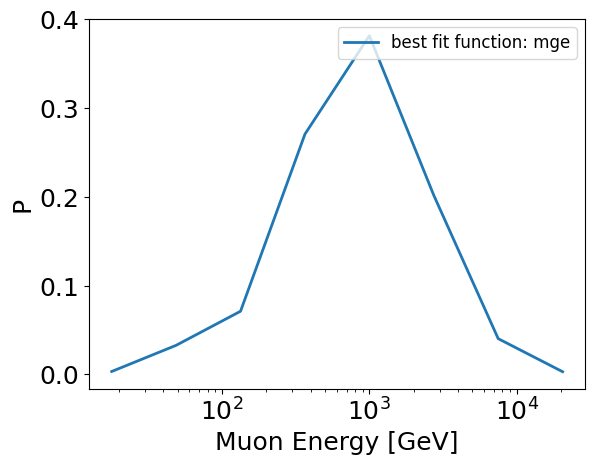

In [6]:
plt.plot(bc1, f1, label=f'best fit function: {func1}', linewidth=2)
#plt.plot(bc1, f1, label=f'best fit function: {func1}', linewidth=2)
#sample_x = np.random.choice(bc1, p=f1norm)
#index = np.argmin(np.abs(bc1 - sample_x))  # Find the index of the closest x value
#sample_y = f1[index]
#plt.scatter(sample_x,sample_y, color='red',
#            label = f'{np.round((sample_x),0)} GeV , P = {np.round(sample_y,3)}')
#plt.scatter(sample_x,.05, color='blue',
#            label = f'{np.round((sample_x),0)} GeV , P = {np.round(sample_y,3)}')
#print(sample_x)
plt.xscale('log')
plt.ylabel('P')
plt.xlabel('Muon Energy [GeV]')
plt.legend(loc = 'upper right',fontsize=12)

In [7]:
file = dataio.I3File('/data/user/zrechav/simulation_scripts/22646/step_0_inject_veto_muons/00000-00999/Level0.0_nugen_IC86.2012_pass2.022646.000000.i3.bz2','r')

In [8]:
EnergySample = [] 
Muon1_Energy = []
Muon2_Energy = []
Muon3_Energy = []
Muon4_Energy =[]
MultiplicitySample = []
EventID =[]
count = 0
while file.more():
    
    try:
        #count +=1
        frame = file.pop_daq()
        count +=1
        if count % 1000 == 0:
            print(frame['OldEventID'].value)
        if count >= 3001:
            break
    
        #if frame['OldEventID'].value == 717: #.run_id == 38312215 and frame['I3EventHeader'].event_id == 14002:#103:
        #if frame['OldEventID'].value == 1261: #THE ONE I USED FOR HIGH ENERGY CHECKS
        if frame['OldEventID'].value == 1058:
            eventid = frame['OldEventID'].value
            injection_info = frame['MCVetoMuonInjectionInfo']
            muon1_energy = injection_info['muon_1_energy']
            muon2_energy = injection_info['muon_2_energy']
            muon3_energy = injection_info['muon_3_energy']
            muon4_energy = injection_info['muon_4_energy']
            sample = injection_info['EnergySample']
            #print('Im HERE')

            EnergySample.append(sample)
            Muon1_Energy.append(muon1_energy)
            Muon2_Energy.append(muon2_energy)
            Muon3_Energy.append(muon3_energy)
            Muon4_Energy.append(muon4_energy)
            EventID.append(eventid)
            #break
    except:
        continue
    

1058.0
1058.0
1058.0


In [9]:
Muon1_Energy = np.array(Muon1_Energy)
Muon2_Energy = np.array(Muon2_Energy)
Muon3_Energy = np.array(Muon3_Energy)
Muon4_Energy = np.array(Muon4_Energy)

In [10]:
M1_ONLY = []
M1_M2 = []
M2_M2 = []
M1_M3 = []
M2_M3 = []
M3_M3 = []
M4_M4 = []
for i in range(len(Muon1_Energy)):
    if Muon2_Energy[i] ==0. and Muon3_Energy[i] == 0. and Muon4_Energy[i] == 0:
        M1_ONLY.append(Muon1_Energy[i])

for i in range(len(Muon1_Energy)):
    if Muon1_Energy[i] >0. and Muon2_Energy[i] >0. and Muon3_Energy[i] == 0. and Muon4_Energy[i] == 0:
        M1_M2.append(Muon1_Energy[i])
        M2_M2.append(Muon2_Energy[i])
        
for i in range(len(Muon1_Energy)):
    if Muon1_Energy[i] >0. and Muon2_Energy[i] >0. and Muon3_Energy[i] > 0. and Muon4_Energy[i] == 0:
        M1_M3.append(Muon1_Energy[i])
        M2_M3.append(Muon2_Energy[i])
        M3_M3.append(Muon3_Energy[i])
for i in range(len(Muon1_Energy)):
    if Muon1_Energy[i] >0. and Muon2_Energy[i] >0. and Muon3_Energy[i] > 0. and Muon4_Energy[i] > 0:
        M4_M4.append(Muon4_Energy[i])


In [20]:
len(M1_M3)

12

In [ ]:
# fig, ax = plt.subplots(figsize=(7., 7.), dpi=300)
# #mult_list = [len(M1_ONLY)/1000 * 100, len(M2_M2)/1000 * 100, len(M3_M3)/1000 * 100, 2/1000 * 100]
# #o_bin = 100 - mult_list[0]
# #print(o_bin)
# mult_list = [316/1000 * 100, 277/1000 * 100, 215/1000 * 100, 192/1000 * 100]
# #mult_exp = [96.9, 2.5, .36, .11]
# mult_exp = [64.56,20.83,8.4,6.19]
# # Error value
# error_value = np.sqrt(1000)

# # X values
# mult_x = [1, 2, 3, 4]
# plt.xticks([1,2,3,4],labels = ['1','2','3','4'])

# # Adjust error bars
# lower_limits = np.clip(mult_list - error_value, 0, 100)
# upper_limits = np.clip(mult_list + error_value, 0, 100)

# # Scatter plot with adjusted error bars
# plt.errorbar(mult_x, mult_list, yerr=[mult_list - lower_limits, 
#                                       upper_limits - mult_list],
#              fmt='o', label='sampled', capsize=5, color = 'red')
# plt.errorbar(mult_x, mult_exp, yerr=[mult_exp - 
#                                      np.clip(mult_exp - error_value, 0, 100), 
#                                        np.clip(mult_exp + error_value, 0, 100) - mult_exp]
#              ,
#              fmt='o', label='predicted', capsize=5, color = 'k',alpha=.5)

# plt.legend(loc='upper right')
# plt.ylabel('%')
# plt.xlabel('Muon multiplicity')
# #plt.ylim(0, 100)
# plt.show()

[0.    0.    0.006 0.    0.013 0.    0.019 0.    0.013 0.    0.001]


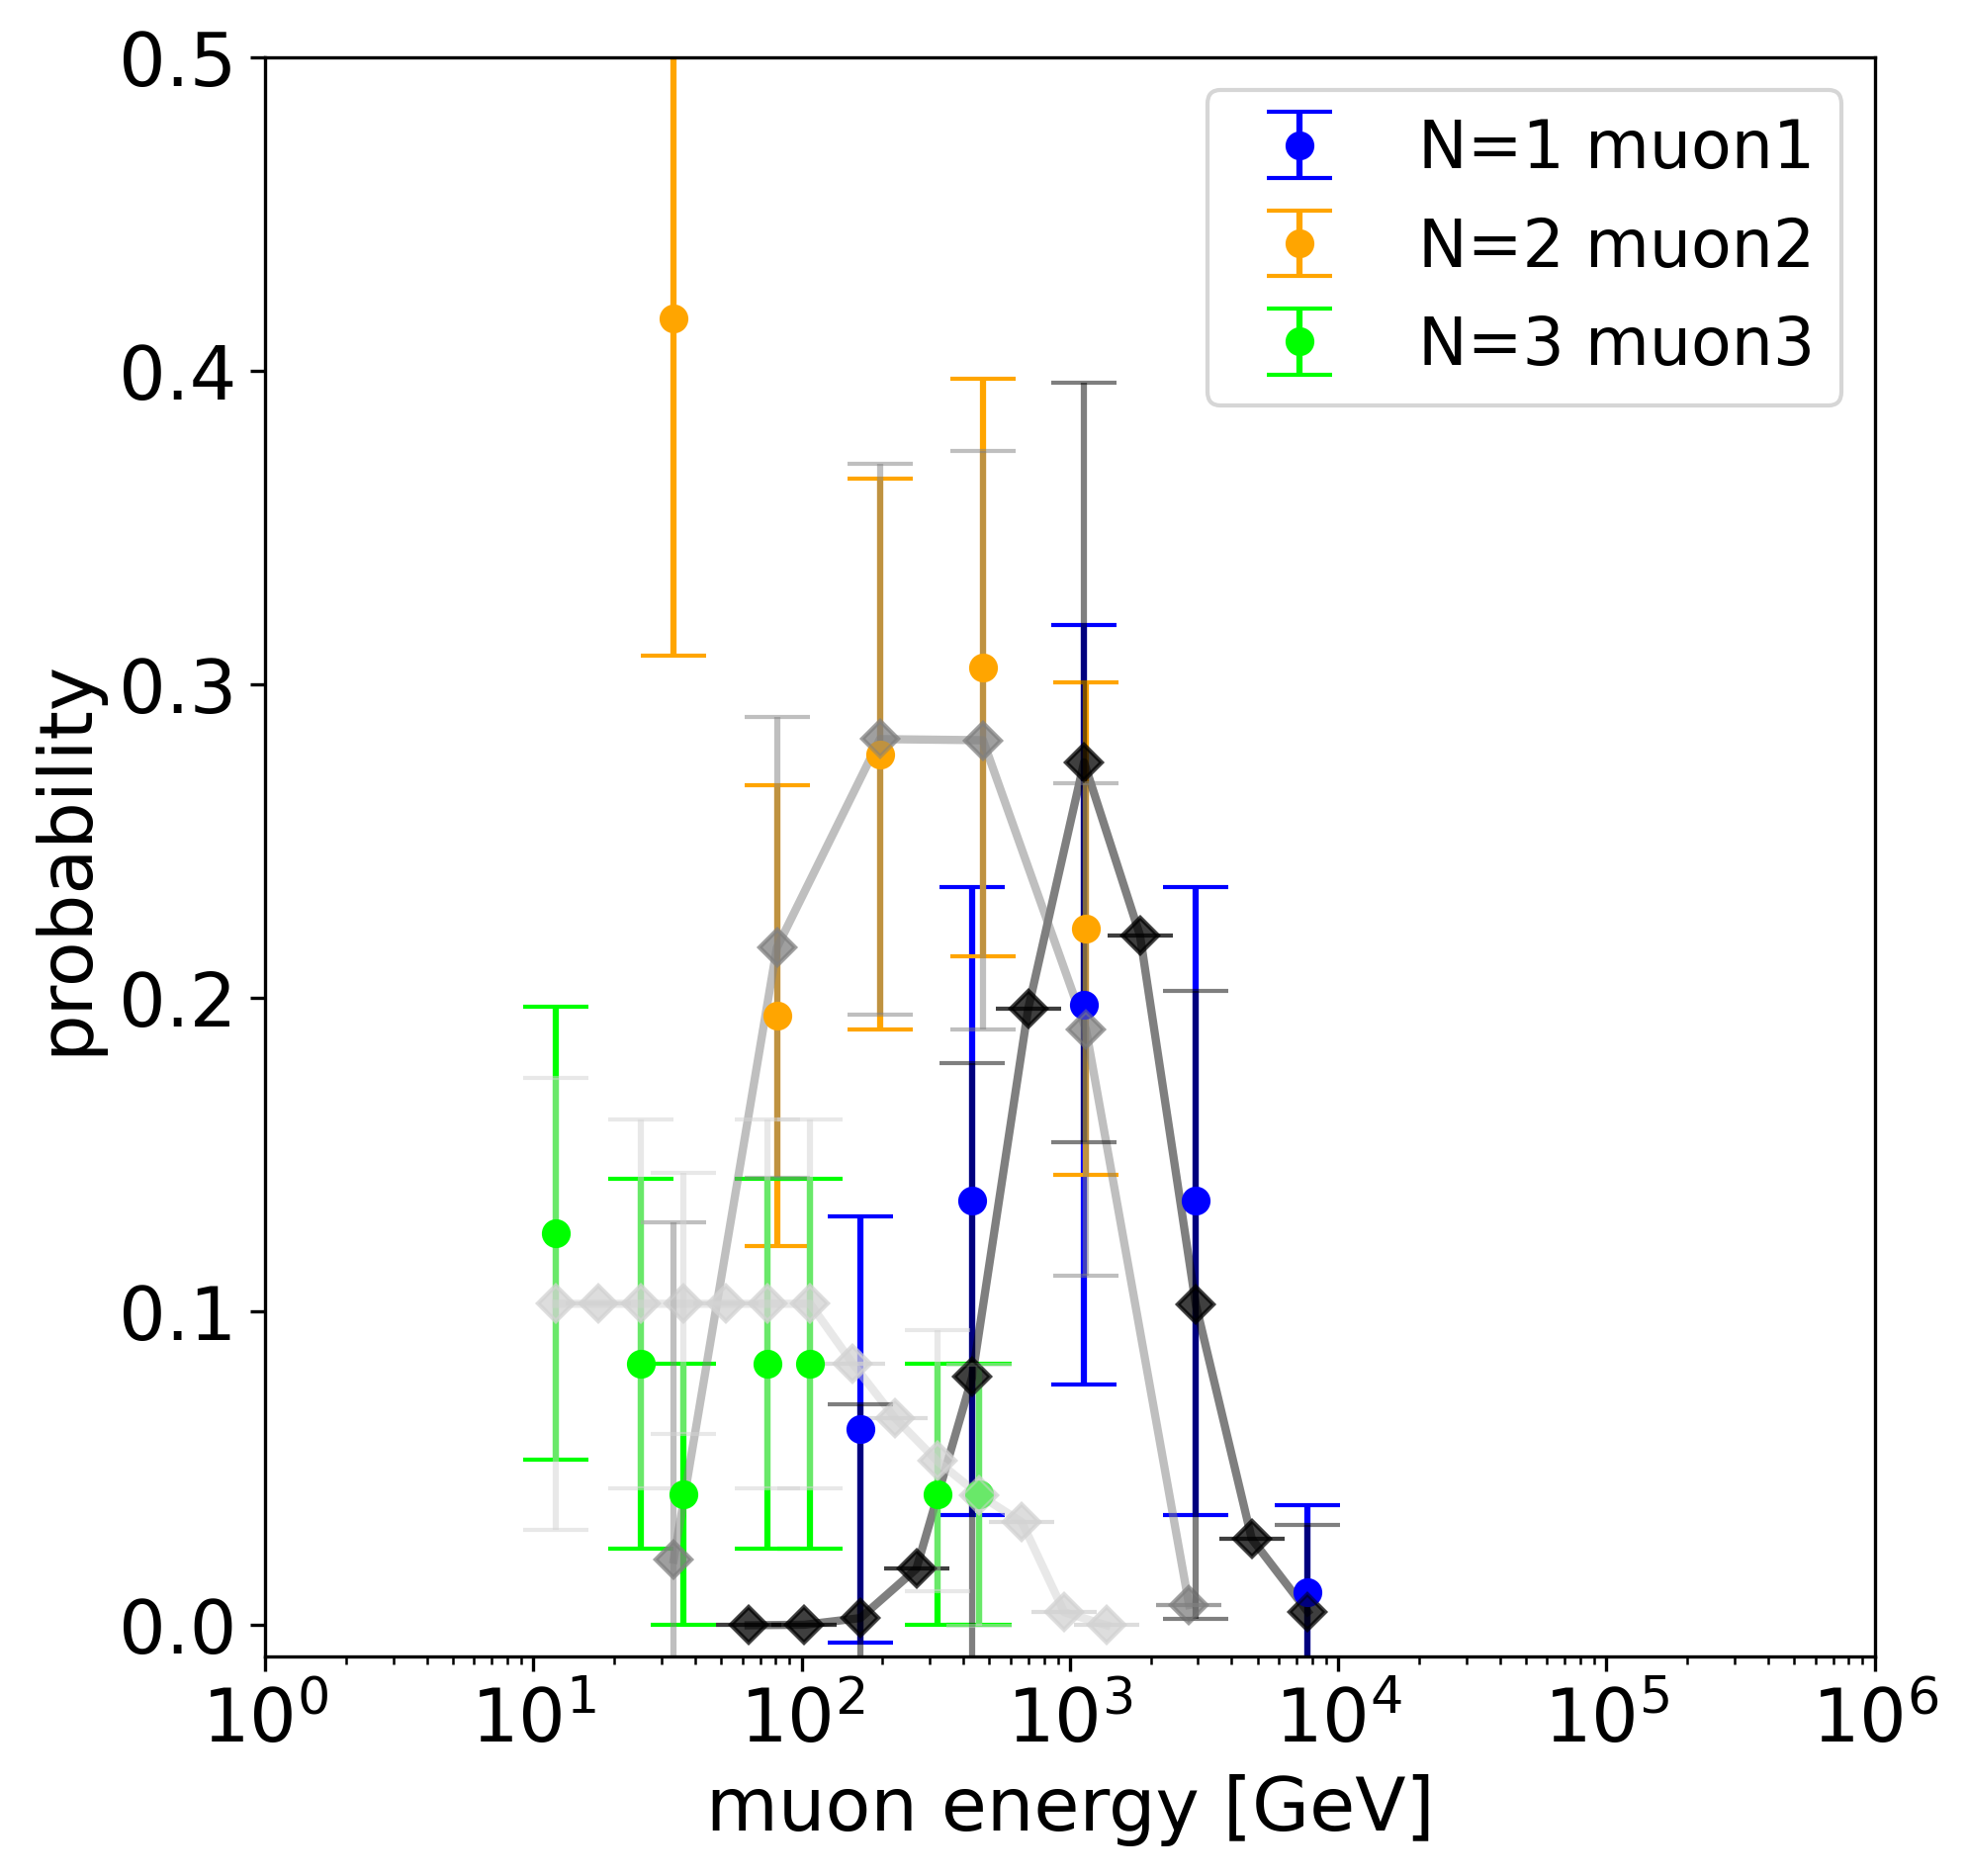

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Muon1_Energy and Muon2_Energy are defined
# Example: Muon1_Energy = np.random.lognormal(mean=3, sigma=1, size=1000)
# Example: Muon2_Energy = np.random.lognormal(mean=3, sigma=1, size=1000)

# Create a mask for Muon2_Energy where values are equal to 0
#mask = [val == 0 for val in Muon2_Energy]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(7., 7.), dpi=300)

# Define the bins for the histogram
#bins = np.array([1.00009988e+01, 4.41995455e+01, 1.95340472e+02, 8.63309782e+02,
#         3.81540892e+03, 1.68622499e+04, 7.45229348e+04])
bins1 = np.array([  49.83889242,   80.5377018 ,  130.14577765,  210.31048889,
          339.85352838,  549.19001596,  887.46959629, 1434.11617374,
         2317.47567283, 3744.95009017, 6051.69294431, 9779.29921905])
bin_centers1 = bc1

bins2 = np.array([  21.41441118,   51.87412078,  125.65950958,  304.39672252,
          737.36850469, 1786.19634012, 4326.86959803])
bin_centers2 = bc2

bins3 = np.array([  10.11744393,   14.5525629 ,   20.9318765 ,   30.10764887,
           43.30574568,   62.28940749,   89.59481529,  128.86991946,
          185.361799  ,  266.61766121,  383.49313425,  551.60255833,
          793.40503175, 1141.2049036 , 1641.46757316])
bin_centers3 = bc3
# Plot the histogram for Muon1_Energy using the mask
#ax.hist(Muon1_Energy, bins=bins, alpha=0.5, label='Muon1 Energy', color='blue')
#counts, edges = np.histogram((M1), bins=bins)
counts1, edges = np.histogram((M1_M2), bins=bins1)
counts2, edges = np.histogram((M2_M2), bins=bins2)
counts3, edges = np.histogram((M3_M3), bins=bins3)
#counts3, edges = np.histogram((Muon3_Energy), bins=bins)
#counts4, edges = np.histogram((Muon4_Energy), bins=bins)

# Calculate the bin centers

#error = np.sqrt(counts)
error1 = np.sqrt(counts1)
error2 = np.sqrt(counts2)
error3 = np.sqrt(counts3)

# Filter out zero counts and corresponding bin centers and errors
# mask = counts > 0
# filtered_bin_centers = bin_centers[mask]
# filtered_counts = counts[mask]
# filtered_error = error[mask]
# print(len(filtered_counts))

# Create an error bar plot
#ax.errorbar(filtered_bin_centers, filtered_counts/276, yerr=filtered_error/276,
#            label='sampled energy', color='blue', fmt='o', capsize=8)
print(counts1/1000)
ax.errorbar(bin_centers1[counts1>0], counts1[counts1>0]/96, yerr=error1[counts1>0]/36,
            label='N=1 muon1', color='blue', fmt='o', capsize=8)

ax.errorbar(bin_centers2[counts2>0], counts2[counts2>0]/36, yerr=error2[counts2>0]/36,
             label='N=2 muon2', color='orange', fmt='o', capsize=8)

ax.errorbar(bin_centers3[counts3>0], counts3[counts3>0]/24, yerr=error3[counts3>0]/24,
            label='N=3 muon3', color='lime', fmt='o', capsize=8)
#ax.errorbar(bin_centers, counts2/1000, yerr=error2/1000,
#            label='M2_M2', color='orange', fmt='o', capsize=8)

# Set labels and title


#error = np.sqrt(len(M2))
# Plot the line using the bin centers and counts
# ax.scatter(bin_centers, counts, label='N=2 Muon2 Energy', color='blue', marker='o')
# ax.fill_between(bin_centers, 
#                 (counts - error),  # Lower bound
#                 (counts + error),  # Upper bound
#                 color='blue', alpha=0.2, label='Error band')
#ax.plot(bin_centers, counts1, label='Muon1 Energy', color='purple', marker='o')
#ax.plot(bin_centers, counts2, label='Muon2 Energy', color='red', marker='o')
#ax.plot(bin_centers, counts3, label='Muon3 Energy', color='orange', marker='o')
#ax.plot(bin_centers, counts4/1000, label='Muon4 Energy', color='green', marker='o')
# Create a second y-axis
#twin = ax.twinx()

# Assuming bc1 and f1 are defined
# Example: bc1 = np.linspace(1, 6, 100), f1 = np.sin(bc1)  # replace with actual data
ax.plot(bc1, (f1), linewidth=2,  color='k',marker = 'D',alpha=.5)

ax.plot(bc2, (f2), linewidth=2,  color='gray',marker = 'D',alpha=.5)

ax.plot(bc3, (f3), linewidth=2,  color='lightgray',marker = 'D',alpha=.5)
#twin.errorbar(bc1, f1, yerr=error/2000,
#             color='black', fmt='D', capsize=8,alpha=.5,
#              label = 'predicted energy')
ax.errorbar(bc1, f1, yerr=error1/36,
             color='black', fmt='D', capsize=8,alpha=.5,#label='predicted energy'
              )

ax.errorbar(bc2, f2, yerr=error2/36,
             color='gray', fmt='D', capsize=8,alpha=.5
              )

ax.errorbar(bc3, f3, yerr=error3/24,
             color='lightgray', fmt='D', capsize=8,alpha=.5
              )
# Set the x-axis to logarithmic scale
#twin.set_xscale('log')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(1,1e6)
ax.set_ylim(-0.01,.50)
#ax.set_ylim(-.01,.20)
#twin.set_yticks([])
ax.set_yticks([0.0,0.1,0.20,0.3,0.40,.5])
ax.set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5'])
#ax.set_yticks([0.0,0.05,.10,0.15,0.20])
#ax.set_yticklabels(['0.0','0.05','0.10','0.15','0.20'])
#twin.set_xlim(1e1,1e6)
#twin.set_yscale('log')

# Add labels and title
ax.set_xlabel('muon energy [GeV]')
ax.set_ylabel('probability')
#twin.set_ylabel('Overlay Line Value')

# Add legends
ax.legend(loc='upper right', fontsize = 16)
#twin.legend(loc='upper right')

# Show the plot
plt.show()


In [29]:
np.cos(1.40964)

0.1604596572087612

In [11]:
np.cos(0.718786)

0.7526056679319709

In [32]:
from IPython.display import display, Math

# Define the functions as strings in LaTeX format
function_1 = r"f(x) = \begin{cases} A e^{-\frac{1}{2} \left(\frac{\log(x) - \mu}{\sigma_1}\right)^2}, & \text{if } \log(x) < \mu \\ A e^{-\frac{1}{2} \left(\frac{\log(x) - \mu}{\sigma_2}\right)^2}, & \text{if } \log(x) \geq \mu \end{cases}"

function_2 = r"g(x) = \begin{cases} A e^{-\frac{1}{2} \left|\frac{\log(x) - \mu}{\sigma_1}\right|^p}, & \text{if } \log(x) < \mu \\ A e^{-\frac{1}{2} \left|\frac{\log(x) - \mu}{\sigma_2}\right|^p}, & \text{if } \log(x) \geq \mu \end{cases}"

function_3 = r"h(x) = \begin{cases} A e^{-\frac{1}{2} \left|\frac{\log(x) - \mu}{\sigma_1}\right|^p}, & \text{if } \log(x) < \mu \\ A e^{-\frac{1}{2} \left|\frac{\log(x) - \mu}{\sigma_2}\right|^p} e^{-q(\log(x) - \mu)}, & \text{if } \log(x) \geq \mu \end{cases}"

# Display the functions
display(Math(function_1))
display(Math(function_2))
display(Math(function_3))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>